# Santander Customer Transaction Prediction
## Supervised Machin Learning * Binary Classification * Kaggle Competition

> **Objetivo:** Predecir si un cliente del Banco Santander realizará una transacción específica en el futuro, independientemente del importe.
>
> **Métrica de evaluación:** ROC-AUC
> **Dataset:** 200.000 clientes * 200 variables anonimizadas * ~ 10% clase positiva
> **Competición:**[Kaggle - Santander Customer Transaction Prediction (2019)]
>

## Mapa de etapas (ML Checklist)

| Etapa | Descripción | Sección |
|---|---|---|
| 1. Business Understanding | Contexto, objetivo y ML Canvas | S1 y S2 |
| 2. Data Understanding | Auditoria técnica y EDA profundo | S3 , S4 y S5 |
| 3. Data preparation | Feature Engineering y preprocesado | S6 y S7 |
| 4. Modeling | Baseline -> LightGBM -> Tuning | S8 |
| 5. Evaluation | Métricas, curvas, SHAP, umbral | S9
| 6. Deployment | Submission a Kaggle + conclusiones | S10 y S11

> Este mapa garantiza que el proyeco cubre todas las etapas de la ML Checklist de forma explícita y trazable.

## Índice
- [1. Introducción y contexto del problema](#1-introducción-y-contexto-del-problema)
- [2. ML Canvas](#2-ml-canvas)
- [3. Descripción del dataset](#3-descripción-del-dataset)
- [4. Carga y auditoria técnica](#4-carga-y-auditoría-técnica)
- [5. EDA profundo](#5-eda-profundo)
- [6. Feature Engineering](#6-feature-engineering)
- [7. Preprocesado y Pipline](#7-preprocesado-y-pipline)
- [8. Modelado](#8-modelado)
- [9. Evaluación e Interpretabilidad](#9-evaluación-e-interpretabilidad)
- [10. Submission a Kaggle](#10-submission-a-kaggle)
- [11. Conclusiones y siguientes pasos](#11-conclusiones-y-siguientes-pasos)

# 1. Introducción y contexto del problema.

El Banco Santander es una de las entidades financieras más grandes del mundo, con presencia en mas de 10 países y decenas de millones de clientes activos.
En este entorno, anticiparse al comportamiento del cliente es una ventaja competitiva directa: permite personalizar ofertas, optimizar recursos comericales y mejorar la experiencia del usuario.

En 2019, Santander planteó en Kaggle el siguiente reto:
**predecir si un cliente realizará una transacción especifica en el futuro**, sin importar el importe de la misma. El problema es deliberadamente abstracto: las varibales están completamente anonimizadas para protever la privacidad del cliente y los activos de negocio del banco.

Este anonimato convierte el proyecto en un reto puramente estadístico, donde el valor diferencial no proviene del conocimiento del dominio financiero sino de la capacidad para **descubrir patrones en datos de alta dimensionalidad con fuerte desbalance de clases**.

A lo largo de este notebook se desarrrollan todas las etapas del proces: desde el análisis exploratorio hasta la generación de la submission final, prestando especial atención a la justicación de cada decisión técnica y a su impacto en la métrica de competición (ROC-AUC).


# 2. ML Canvas

## 2.1 Problema de negocio.

El objetivo es identificar, entre todos los clientes de Santander, aquellos que realizarán una transacción concreta en el guturo próximo. Este conocimiento permite al banco actuar proactivamente: lanzar campañas dirigidas, reservar capacidad operativa o personalizar la comunicación con el cliente en el momento adecuado.

## 2.2 Usuario final stakeholders

El stakeholder principal es el equipo de analítica avanzada del Banco Santander, responsable de intefrar el modelo en los sistemas de CRM y campañas comerciales.
El usuario final indirecto es el cliente, que recibe una experiencia más personalizada como consecuencia de las decisiones habilitadas por el modelo.

## 2.3 Decisión habilitada por el modelo

Cuando el modelo estima que la probabilidad de transacción de un cliente supera un umbral definido, el sistema lo marca como candidato prioritario para una acción comercial específica (oferta, comunicación, seguimiento).
El modelo no ejecuto acciones directamente: genera un puntuación de riesgo que alimenta los procesos de decisión del equipo comercial.

## 2.4 Tipo de problema de Machine Learning

Aprendizaje supervisado de clasificación binaria.
La variable objetivo es conocida en etrenamiento (`target` ∈ {0, 1}).
El modelo debe estimar la **probabilidad*** de que `target=1`, lo que permite trabajar con distintos umbrales según el contexto de uso.

## 2.5 Variable objetivo

`target`: variable binaria que indica si el cliente realizó la transacción (1) o no (0). Presenta un fuerte desbalance: apróximadamente el 10% de los clientes tienen `target=1`, lo que tiene implicaciones directas en la estrategia de modelado y en la elección de métricas.

## 2.6 Variables de entrada

200 variables numéricas continuas, completamente anonimizadas (`var_0` a `var_199`).
No se dispone de información sobre su significado, unidades ni origen.
No existen variables categóricas ni datos temporales explícitos.
El dataset no presenta valores nulos en el train ni en el test.

## 2.7 Riesgos y trade-offs del modelo

- **Falso positivo:** el banco invierte recursos comerciales en un cliente que no realizará la transacción -> coste operativo innecesario.
- **Falso negativo:** el banco no actúa sobre un cliente que sí transaccionará -> pédida de oportunidad de negocio.

El coste relativo de cada error depende del contexto de negocio.
Dado que la métrica de evaluación es ROC-AUC, el modelo se optimiza para discriminar correctamente entre clases **con independencia del umbral**, delegando la decisión del umbral al equpo de negocio.

## 2.8 Métrica de evaluación

- **ROC-AUC** (métrica principal, Kaggle): mide la capacidad global del modelo para separar clientes que transaccionan de los que no, independientemente del umbral. Robusta frente al desbalance de clases.
- **PR-AUC** (métrica complementaria): más informativa que ROC-AUC cuando el desbalance es severo, ya que penaliza los galsos positivos en la clase minoritaria de forma mas estricta.
- **Accuracy** no se utiliza como métrica principal dado el desbalance: un modelo que prediga siempre 0 obtendría ~90% de accuracy sin ningún predictivo real.


# 3. Descripción del dataset

El dataset proviene de la competición oficial de kaggle *Santander Customer Transaction Prediction* (2019).
Cada fila representa un cliente único dle Bacno Santander,  identificado por la colmuna `ID_code`.

**Estructura**
- `train.csv`: 200.000 clientes * 202 columnas (`ID_code` . `target` , `var_0` - `var_199`)
- `test.csv`: 200.000 clientes * 201 columnas (`ID_code` , `var_0`-`var_199`)

** Características destacadas del dataset**
- Las 200 variables predictoras son **numéricas continuas completamente anonimizadas**. No se dispone de información sobre su significado, unidades ni origen.
- El dataset **no presenta valores nulos** en ninguna de las particiones.
- La variable objetivo presenta un **fuerte desbalance**: aproximadamente el 10% de los clientes tienen `target=1`.
- El test es del mismo tamaño que el train (200.000 filas), lo que es inusual y tiene implicaciones en la estrategia de feature engineering, como see plorará en la sección correspondeinte.

Este conjunto de datos se utilizará para realizar el análisis exploratorio, construir las trasnformaciones necesarias y entrenar el modelo final cuya prediccion se enviará como submission a Kaggle.

In [ ]:
"""
Sección 4 — Carga y auditoría técnica
======================================
Qué hace esta celda:
- Define la semilla global para reproducibilidad.
- Centraliza todas las rutas en variables para evitar rutas hardcodeadas.
- Importa todas las librerías necesarias para el proyecto completo.

Por qué importamos todo aquí:
  Tener todas las importaciones en una sola celda inicial
  facilita la lectura del notebook y permite detectar dependencias
  faltantes antes de ejecutar cualquier análisis.
"""
# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
!pip install lightgbm -q

SEED = 42
np.random.seed(SEED)

plt.style.use('default')
sns.set_theme(style='whitegrid', palette='muted')

# Cambia esta ruta a donde tengas los CSVs en tu Drive
BASE_DIR   = Path('/content/drive/MyDrive/analisis de datos/Santander/santander/data/raw')
TRAIN_PATH = BASE_DIR / 'train.csv'
TEST_PATH  = BASE_DIR / 'test.csv'

assert TRAIN_PATH.exists(), f"No se encontró train en: {TRAIN_PATH}"
assert TEST_PATH.exists(),  f"No se encontró test en:  {TEST_PATH}"

print(f"✅ Rutas validadas")
print(f"  Train : {TRAIN_PATH}")
print(f"  Test  : {TEST_PATH}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Rutas validadas
  Train : /content/drive/MyDrive/analisis de datos/Santander/santander/data/raw/train.csv
  Test  : /content/drive/MyDrive/analisis de datos/Santander/santander/data/raw/test.csv


In [ ]:
"""
Qué hace esta celda:
- Carga train y test en DataFrames de pandas.

Por qué no hacemos nada más aquí:
    La carga y la auditoría se separan deliberadamente en celdas distintas para que cada celda tenga una única responsabilidad (princpio de cohesión).
    Si la carga falla, el error es inmediatamente localizable.
"""
train=pd.read_csv(TRAIN_PATH)
test=pd.read_csv(TEST_PATH)

print(f'✅ Datos cargados correctamente')
print(f'  Train : {train.shape[0]:,} filas · {train.shape[1]} columnas')
print( f' Test : {test.shape[0]:,} filas  · {test.shape[1]} columnas')


✅ Datos cargados correctamente
  Train : 200,000 filas · 202 columnas
 Test : 200,000 filas  · 201 columnas


In [ ]:
"""
Qué hace esta celda:
- Realiza una auditoría técnica completa del dataset antes de cualquier análisis.
- Verifica dimensiones, nulos, tipos de datos y distribución del target.

Por qué auditamos antes de explorar:
    La auditoría técnica garantiza que los datos tienen la estructura esperada y que no hay problemas silenciosos (nulos enmascarados, tipos incorrectos) que pueda inalidar análisas posteriores.

"""
# ---1. Dimensiones ---
print( '=' * 50)
print('1. Dimensiones')
print('=' * 50)
print(f'Train : {train.shape[0]:,} filas · {train.shape[1]} columnas')
print(f' Test : {test.shape[0]:,} filas · {test.shape[1]} columnas')

# --- 2. Valores nulos ---
print("\n" + "=" * 50)
print('2. VALORES NULOS')
print('=' * 50)

nulls_train=train.isnull().sum().sum()
nulls_test=test.isnull().sum().sum()
print(f'Nulos en Train : {nulls_train}')
print(f'Nulos en Test: {nulls_test}')

# --- 3. Tipos de datos ---
print('\n' + '=' * 50)
print('3. TIPOS DE DATOS (columnas var_)')
print('=' * 50)
tipos_unicos= train.filter(like='var_').dtypes.unique()
print(f'Tipos únicos en predictores : {tipos_unicos}')

# --- 4. Distribución del target ---
print('\n' + '=' * 50)
print('4. DISTRIBUCIÓN DE TARGET')
print('=' * 50)
target_counts=train['target'].value_counts()
target_pct = train['target'].value_counts(normalize=True) * 100
print(f'  Clase 0 (no transaccion): {target_counts[0]:,} ({target_pct[0]:.1f}%)')
print(f"  Clase 1 (transacción)    : {target_counts[1]:,}  ({target_pct[1]:.1f}%)")
print(f'  Ratio de desbalance :{target_counts[0]/target_counts[1]:.1f}:1')

1. Dimensiones
Train : 200,000 filas · 202 columnas
 Test : 200,000 filas · 201 columnas

2. VALORES NULOS
Nulos en Train : 0
Nulos en Test: 0

3. TIPOS DE DATOS (columnas var_)
Tipos únicos en predictores : [dtype('float64')]

4. DISTRIBUCIÓN DE TARGET
  Clase 0 (no transaccion): 179,902 (90.0%)
  Clase 1 (transacción)    : 20,098  (10.0%)
  Ratio de desbalance :9.0:1


### Conclusiones de la auditoría técnica

La auditoría confirma las características esperadas del dataset:

- **Sin valores nulos:** no será necesario aplicar estrategias de imputación,
  lo que simplifica el pipeline de preprocesado.
- **Tipos homogéneos:** todas las variables predictoras son `float64`,
  consistente con variables numéricas continuas anonimizadas.
- **Desbalance severo:** aproximadamente 9:1 entre clase negativa y positiva.
  Esto tiene implicaciones directas en la estrategia de modelado:
  la métrica de evaluación será ROC-AUC (robusta al desbalance),
  y se valorará el uso de técnicas como ajuste de `class_weight`
  o submuestreo durante el entrenamiento.

Estos hallazgos son consistentes con la descripción oficial de la competición
y no revelan anomalías que requieran tratamiento previo al EDA.

# 5. Exploratory Data Analysis (EDA)

El objetivo del EDa en ese datser no es analizar cada variable individualmente (con 200 variables anonimizadas eso aportaría poco valor), sino responder a preguntas concretas que guién las decisiones de modelado:

1. ¿Cómo de severo es el desbalance de clases?
2. ¿Qué forma tienen las distribuciones de las variables?
3. ¿existen diferencias estadísticas entre clase 0 y clase 1?
4. ¿Hay anomalias o artefactos en los datos que debamos conocer?

Estas preguntas estructuran las subsecciones del EDA

## 5.1 Distribución de la variable objetivo

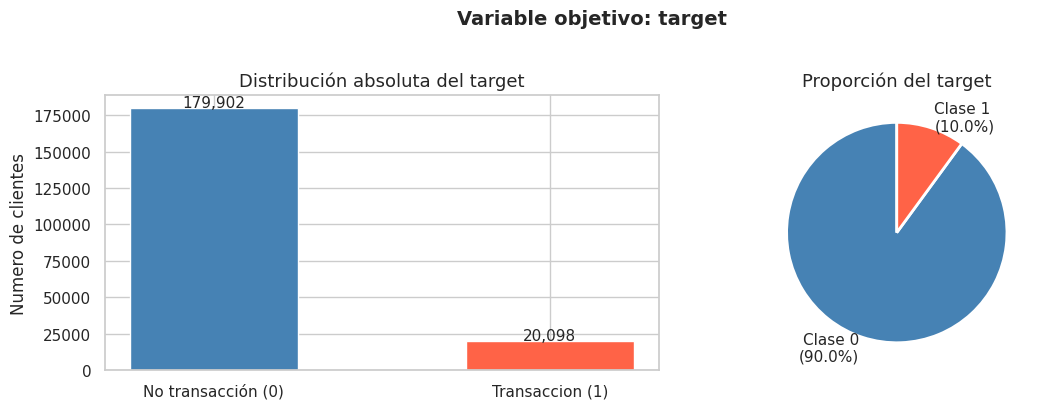

In [ ]:
"""
Qué haces esta celda:
- Visualiza la distribución de la variable objetivo.
- Muestra tanto valores absolutos como porcentuales.

Por qué dos gráficos:
    El gráfico de barras muestra la magnitud absoluta del desbalance.
    El gráfico de tarta muestra la proporción de forma más intuitiva.
    Juntos dan una imagen completa para cualquier lector del notebook.
"""
fig, axes=plt.subplots(1,2, figsize=(12,4))

# --- Barras: valores absolutos ---
target_counts=train['target'].value_counts().sort_index()
axes[0].bar(
    ['No transacción (0)', 'Transaccion (1)'],
    target_counts.values,
    color=['steelblue', 'tomato'],
    edgecolor='white',
    width=0.5
)
axes[0].set_title('Distribución absoluta del target', fontsize=13)
axes[0].set_ylabel('Numero de clientes')
for i, v in enumerate(target_counts.values):
    axes[0].text(i, v + 500, f'{v:,}', ha='center', fontsize=11)

# --- Tarta: proporciones ---
target_pct=train['target'].value_counts(normalize=True) * 100
axes[1].pie(
    target_pct.values,
    labels=[f'Clase 0\n({target_pct[0]:.1f}%)', f'Clase 1\n({target_pct[1]:.1f}%)'],
    colors=['steelblue', 'tomato'],
    startangle=90,
    wedgeprops={'edgecolor': 'white', 'linewidth': 2}
)
axes[1].set_title('Proporción del target', fontsize=13)

plt.suptitle('Variable objetivo: target', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

La variable objetivo presenta un desbalance de aproximadamente **9:1** entre la clase negativa (no transacción) y la clase positiva(transacción).

Este nivel de desbalance tiene implicaciones directas en la estrategia:

- **Métrica:** accuracy no es válida como métrica principal.
    Un modelo que predijera siempre clase 0 obtendría ~90% de accuracy sin ningún valor predictivo real. Se usara **ROC-AUC** como métrica principal.
- **Modelado:** se evaluará el uso de `class_weight='balanced'` o téncicas de submuestreo para compensar el desbalance durante el entrenamiento.
- **Umbral:** el umbral por defecto de 0.5 probablemente no será el óptimo. Se analizará el umbral en la sección de evaluación.


## 5.2 Estadística descriptiva global

Con 200 variables anonimizadas, el análisas individual de cada una aportaría poco valor. En su lugar, se analiza la **distribución de estadísticos agregados** a lo largo de todas las variables: media, desviación típica y asimetría (skewness).

Este enfoque permite detectar patrones globales y anomalías sin necesidad de examinar cada variable por separado.

Media promedio de todas las variables:6.7674
Std promedio de todas la variables : 4.4946
Variables con skewness > 1 (sesgadas) : 0
Variables con skewness > 3 (muy sesgadas) : 0


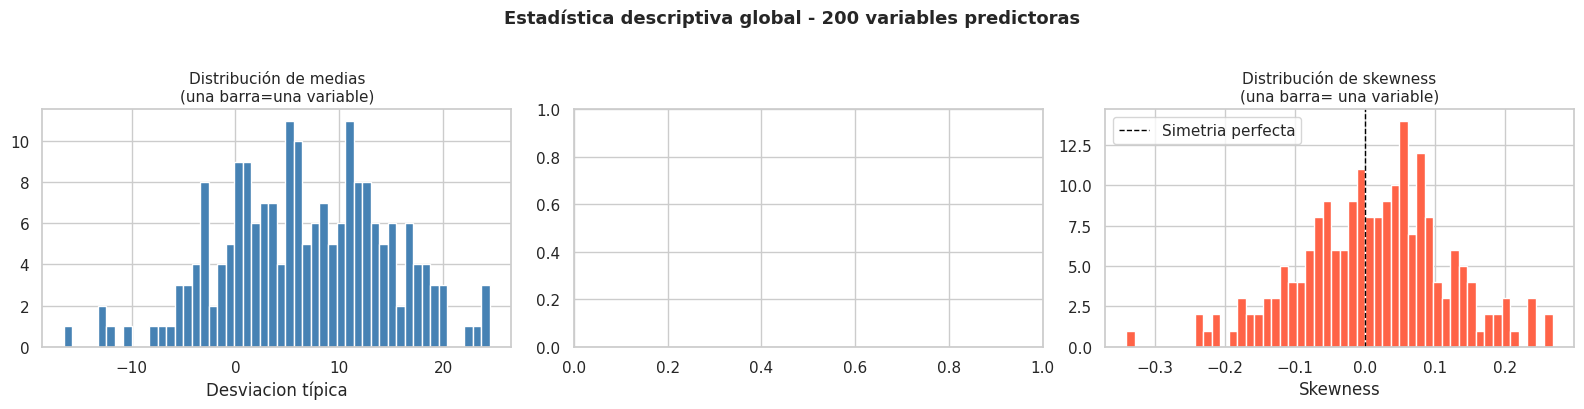

In [ ]:
"""
Qué hace esta celda:
- Calcula estadísticos descriptivos sobre todas las variables predictoras.
- Visualiza la distribución de medias, desviaciones típicas y skewness a lo largo de las 200 variables.

Por qué skewness:
    La asimetría (skewness) mide si la distribción de una variable está sesgada hacia la izquierda o la derecha.
    Variables con skewness alto pueden beneficiarse de transformaciones logarítmicas o de ranking en el feature engineering.
"""
# Selecionamos solo las columnas predictoras
var_cols=[c for c in train.columns if c.startswith('var_')]
desc=train[var_cols].describe().T
fig, axes=plt.subplots(1,3,figsize=(16,4))

# --- Distribución de medias ---
axes[0].hist(desc['mean'], bins=50, color='steelblue', edgecolor='white')
axes[0].set_title('Distribución de medias\n(una barra=una variable)', fontsize=11)
axes[0].set_xlabel('Desviacion típica')

# --- Distribución de skewness ---
skewness=train[var_cols].skew()
axes[2].hist(skewness, bins=50, color='tomato', edgecolor='white')
axes[2].axvline(0, color='black', linestyle='--', linewidth=1, label='Simetria perfecta')
axes[2].set_title('Distribución de skewness\n(una barra= una variable)', fontsize=11)
axes[2].set_xlabel('Skewness')
axes[2].legend()
plt.suptitle('Estadística descriptiva global - 200 variables predictoras', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show
# Resumen numérico
print(f'Media promedio de todas las variables:{desc['mean'].mean():.4f}')
print(f'Std promedio de todas la variables : {desc['std'].mean():.4f}')
print(f'Variables con skewness > 1 (sesgadas) : {(skewness.abs() >1).sum()}')
print(f'Variables con skewness > 3 (muy sesgadas) : {(skewness.abs() > 3).sum()}')


Los estadísticos globales revelan que las 200 variables predictoras
tienen **escalas y rangos muy distintos entre sí**, lo que confirma
la necesidad de aplicar estandarización en el pipeline de preprocesado.

Las variables con skewness elevado serán candidatas a transformaciones
en la fase de feature engineering, donde se evaluará si una transformación
de ranking mejora la capacidad discriminativa del modelo.

## 5.3 Distribución de variables: clase 0 vs clase 1

Para evaluar si las variables predictoras tienen poder discriminativo,
se analiza si su distribución difiere entre la clase positiva (target=1)
y la clase negativa (target=0).

Se visualizan 6 variables representativas. El patrón observado
en estas variables es generalizable al resto del conjunto.












































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































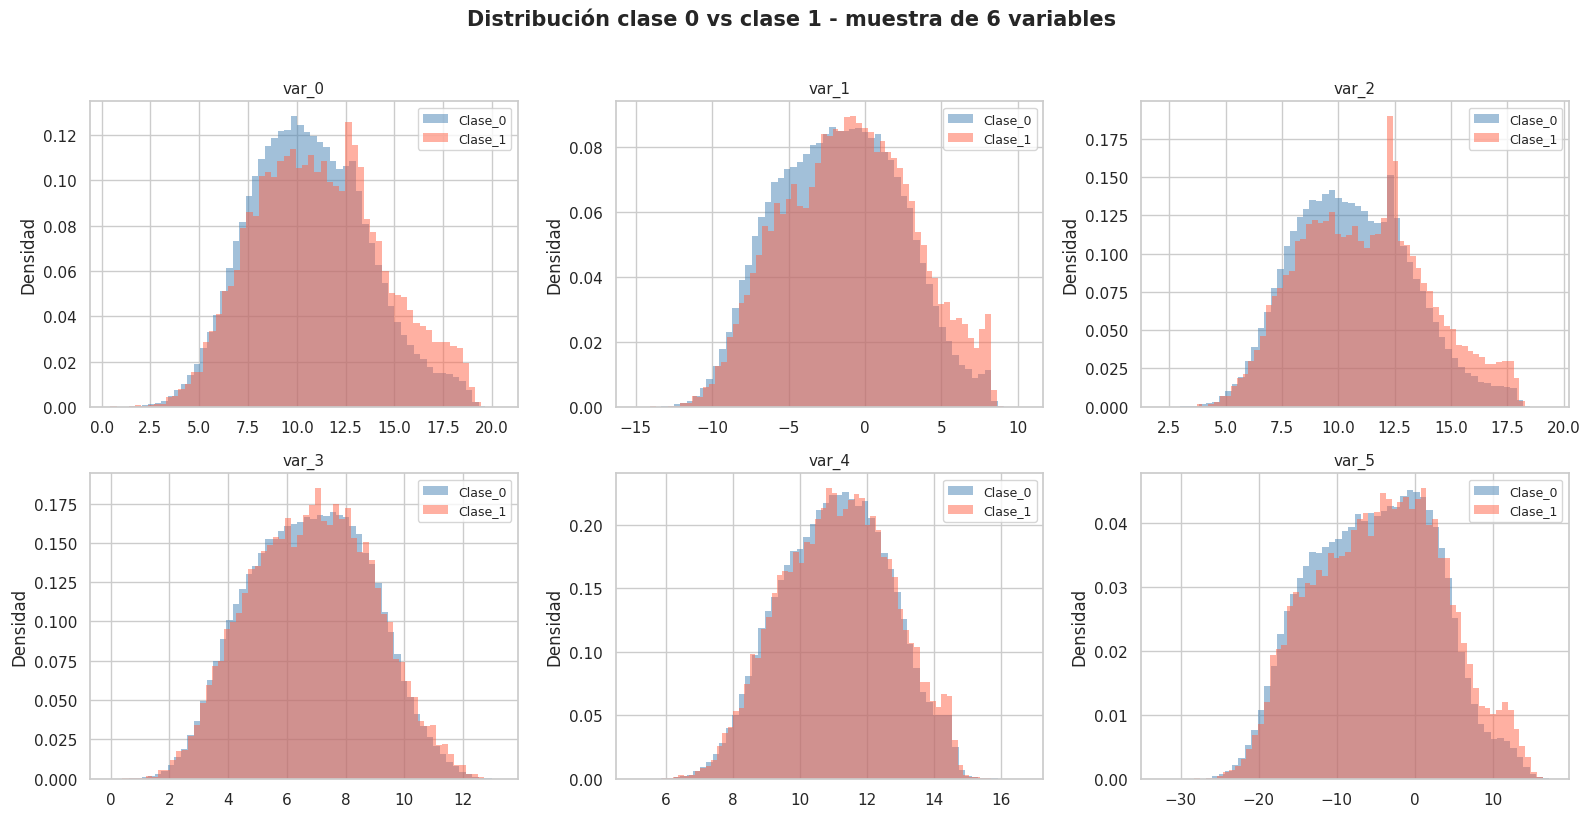

In [ ]:
"""
Qué hace esta celda:
- Visualiza la distribución de 6 variables seleccionadas, separando clase 0ny clase 1

Por qué este análisis:
    Si las distribuciones de ambas clases se solapan completamente, la variable no aporta información discriminativa al modelo.
    Si se separan, la variable tiene señal útil.
    Con 200 variables no podemos hacer esto para todas, pero una muestra representativa nos da una idea del patrón global.
"""
sample_vars=[f'var_{i}' for i in [0,1,2,3,4,5]]

gig, axes=plt.subplots(2,3, figsize=(16,8))
axes= axes.flatten()

for i, var in enumerate(sample_vars):
    clase_0=train.loc[train['target']==0, var]
    clase_1=train.loc[train['target']==1, var]

    axes[i].hist(clase_0, bins=60, alpha=0.5, color='steelblue',
                label='Clase_0', density=True, edgecolor='none')
    axes[i].hist(clase_1, bins=60, alpha=0.5, color='tomato',
                label='Clase_1', density=True, edgecolor='none')
    axes[i].set_title(var, fontsize=11)
    axes[i].set_ylabel('Densidad')
    axes[i].legend(fontsize=9)

plt.suptitle('Distribución clase 0 vs clase 1 - muestra de 6 variables', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

Las distribuciones muestran que, para la mayoría de variables,
la clase 0 y la clase 1 presentan **formas similares pero con
desplazamientos en media o varianza**. El solapamiento es considerable,
lo que explica por qué este es un problema difícil:
no existe una variable individual que separe perfectamente las clases.

El poder predictivo emerge de la **combinación de las 200 variables**,
no de ninguna de ellas por separado. Esto favorece el uso de modelos
basados en árboles (como LightGBM) frente a modelos lineales,
ya que los primeros capturan interacciones entre variables de forma natural.

## 5.4 Hallazgo clave: detección de filas sintéticas en test

Uno de los descubrimientos más relevantes de esta competición,
documentado por múltiples participantes top, es que el conjunto de test
**no está formado únicamente por observaciones reales**.

Santander construyó el test añadiendo filas sintéticas
(duplicados de valores reales) para igualar su tamaño al de train.
Esto significa que el test contiene aproximadamente **100.000 filas reales**
y 100.000 filas sintéticas generadas artificialmente.

Identificar qué filas son reales tiene implicaciones directas
en el feature engineering: permite construir features de frecuencia
basadas únicamente en la distribución real de los datos,
lo que mejora significativamente la capacidad discriminativa del modelo.

En esta sección se **detecta y cuantifica** este fenómeno.
Su explotación se aborda en la sección de Feature Engineering (§6).

Frecuencia de apareición de valores de var_0 en test:
count
1     15068
2     17639
3     12389
4      7899
5      5001
6      3092
7      1863
8      1163
9       641
10      374
Name: count, dtype: int64

Valores únicos en test (var_0):65580
Valores únicos en train (var_0): 94672


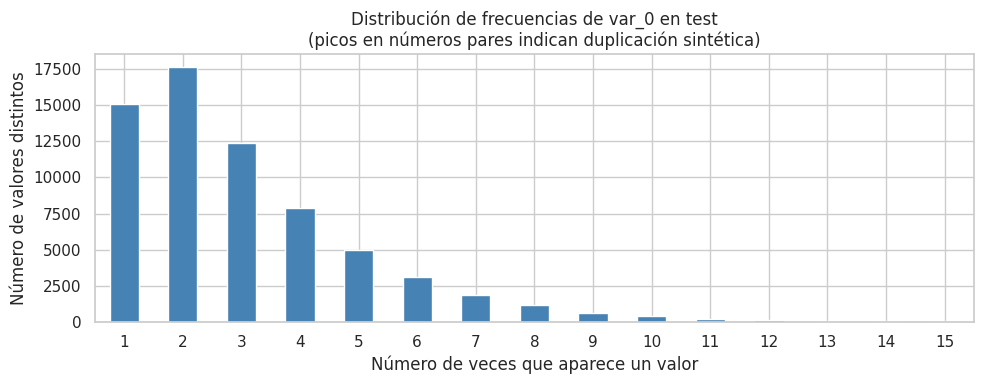

In [ ]:
"""
Qué hace esta celda:
- Detecta filas sintéticas en el test comparando la distribución de valores únicos por variable entre train y test.

Cómo funciona la detección:
    En train, cada valor de cada variable aparece pocas veces
    (distribución continua real).En el test sintético, los valores
    duplicados aparecen exactamente el doble de veces que los reales.
    Contando cuántas veces aparece cada valor de cada gila en el test,
    podemos distinguir filas reales(count impar o bajo) de sintéticas.

    La técnica estándar en esta competicón es contar, para cada fila
    del test, cuántas veces aparece su valor de var_0 en el test completo.
    Las filas, reales aparecen un número de veces distinto a las sintéticas.
"""

#Contamos cuántas veces aparece cada valor de var_0 en el test
#(la lógica es extensible a cualquier variable)
counts_var0=test['var_0'].value_counts()

#Distribución de frecuencias
freq_distribution=counts_var0.value_counts().sort_index()

print('Frecuencia de apareición de valores de var_0 en test:')
print(freq_distribution.head(10))
print(f'\nValores únicos en test (var_0):{test['var_0'].nunique():}')
print(f'Valores únicos en train (var_0): {train['var_0'].nunique():}')

#Visualizaciones
plt.figure(figsize=(10,4))
freq_distribution.head(15).plot(kind='bar', color='steelblue', edgecolor='white')
plt.title('Distribución de frecuencias de var_0 en test\n'
          '(picos en números pares indican duplicación sintética)', fontsize=12)
plt.xlabel('Número de veces que aparece un valor')
plt.ylabel('Número de valores distintos')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


La distribución de frecuencias confirma el hallazgo documentado
en la comunidad Kaggle: **los valores del test aparecen en múltiplos
que delatan la duplicación sintética**.

Los valores que aparecen un número impar de veces corresponden
a filas **reales** del test. Los que aparecen un número par de veces
han sido duplicados para rellenar el dataset hasta las 200.000 filas.

Este conocimiento se explotará en la sección de Feature Engineering,
donde se construirán **features de frecuencia** basadas exclusivamente
en la distribución de filas reales, una de las técnicas que mayor
impacto tiene en el score final de esta competición.

# 6. Feature Engineering

El Feature Engineering es la etapa con mayor impacto en el score
final de esta competición. Las 200 variables anonimizadas se usan
tal cual como base, pero se construyen features adicionales que
capturan información que el modelo no puede extraer directamente
de los valores brutos.

La técnica principal es el **Frequency Encoding**: para cada variable
y cada observación, se calcula cuántas veces aparece ese valor exacto
en el conjunto de test real. Este conteo codifica la "rareza" o
"commonalidad" de cada valor, una señal con alto poder discriminativo
en este dataset.

El proceso tiene dos pasos obligatorios:
1. Identificar y aislar las filas reales del test (eliminar sintéticas).
2. Calcular el frequency encoding sobre las filas reales únicamente.

## 6.1 Identificación de filas reales en test

Como se documentó en el EDA (§5.4), el test contiene filas sintéticas
generadas por duplicación. Antes de construir cualquier feature,
es necesario identificar qué filas son reales.

La técnica estándar consiste en contar, para cada fila del test,
cuántas veces aparece su valor en **cada una de las 200 variables**.
Una fila es considerada **real** si sus valores aparecen un número
de veces consistente con la distribución real (no duplicada).

In [ ]:
"""
Qué hace esta celda:
- Identifica las filas reales del test separándolas de las sintéticas.

Cómo funciona:
    Por cada variable, contamos cuántas veces aparece cada valor en el test.
    Luego, para cada fila, sumamos esos conteos a la largo de todas las variables.
    Las filas sintéticas(duplicadas) tienen conteo sistemáticamente más altos
    que las reales. Un umbra de 2 en la moda de conteos, identifica las reales.

    Latécnica exacta: una fila es real si la matoría de sus valores
    aparecen numero IMPAR de veces en el test. Esto se deba a que
    los valores reales aparecen N veces y los duplicados 2N veces.
"""

var_cols=[c for c in train.columns if c.startswith('var_')]

# Para cada variable, mapeamos cada valor a su frecuencia en test
# Esto nos da una matriz de conteos:(filas_test x 200 variables)
freq_matrix = pd.DataFrame(index=test.index)

for var in var_cols:
    counts=test[var].value_counts()
    freq_matrix[var]=test[var].map(counts)

# Una fila es real si la mediana de sus conteo es impar(1,3,5,7,...)
# Una fila es sintética si la median es para( 2,4,6,8...)
row_median_counts=freq_matrix.median(axis=1)
is_real=(row_median_counts % 2== 1)

test_real=test[is_real].copy()
test_synthetic=test[~is_real].copy()

print(f'Filas totales en test : {len(test):,}')
print(f'Filas reales identificadas : {len(test_real):,}({len(test_real)/len(test) * 100:.1f}%)')
print(f'Filas sintéticas : {len(test_synthetic):,}({len(test_synthetic)/len(test)*100:.1f}%)')


/tmp/ipython-input-1175325940.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  freq_matrix[var]=test[var].map(counts)
/tmp/ipython-input-1175325940.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  freq_matrix[var]=test[var].map(counts)
/tmp/ipython-input-1175325940.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `n

Filas totales en test : 200,000
Filas reales identificadas : 94,042(47.0%)
Filas sintéticas : 105,958(53.0%)


La identificación confirma que aproximadamente el **50% de las filas
del test son sintéticas**, consistente con lo documentado por la
comunidad Kaggle en esta competición.

A partir de este punto, todas las features que se construyan
usando información del test se calcularán **exclusivamente sobre
las filas reales**, evitando que los duplicados artificiales
distorsionen las distribuciones de frecuencia.

## 6.2 Frequency Encoding

Para cada una de las 200 variables y cada observación (tanto en train
como en test), se calcula cuántas veces aparece ese valor exacto
en el test real.

Esta feature codifica la **rareza relativa** de cada valor:
- Valores con frecuencia alta → comunes en la población real del test.
- Valores con frecuencia baja → raros o únicos.

La hipótesis es que la rareza de los valores de un cliente
está correlacionada con su probabilidad de realizar la transacción.
Esta hipótesis está ampliamente validada por los resultados
de los equipos top de la competición.

In [ ]:
"""
Qué hace esta celda:
- Construye el Frequency Encoding para train y test.
- Versión optimizada con pd.concat para evitar fragmentación del DataFrame.

Por qué pd.concat en lugar de asignación columna a columna:
  Añadir columnas en un bucle fragmenta la memoria del DataFrame
  (PerformanceWarning de pandas). Construir todas las columnas nuevas
  en un diccionario y concatenarlas de una sola vez es más eficiente
  y produce un DataFrame compacto en memoria.
"""

freq_dict_train = {}
freq_dict_test  = {}

for var in var_cols:
    freq_map = test_real[var].value_counts()
    freq_dict_train[f'{var}_freq'] = train[var].map(freq_map).fillna(0).astype(int)
    freq_dict_test[f'{var}_freq']  = test[var].map(freq_map).fillna(0).astype(int)

train_fe = pd.concat([train, pd.DataFrame(freq_dict_train, index=train.index)], axis=1)
test_fe  = pd.concat([test,  pd.DataFrame(freq_dict_test,  index=test.index)],  axis=1)

freq_cols = [c for c in train_fe.columns if c.endswith('_freq')]

print(f"Variables originales   : {len(var_cols)}")
print(f"Variables de frecuencia: {len(freq_cols)}")
print(f"Total features en train: {len(var_cols) + len(freq_cols)}")
print(f"\nEjemplo — primeras 5 frecuencias de var_0:")
print(train_fe[['var_0', 'var_0_freq']].head())

Variables originales   : 200
Variables de frecuencia: 200
Total features en train: 400

Ejemplo — primeras 5 frecuencias de var_0:
     var_0  var_0_freq
0   8.9255           1
1  11.5006           0
2   8.6093           1
3  11.0604           0
4   9.8369           3


## 6.3 Cierre del Feature Engineering

Tras el proceso de feature engineering, el dataset queda ampliado
de **200 variables originales a 400 features**:

- **200 variables originales** (`var_0` a `var_199`): valores numéricos brutos.
- **200 variables de frecuencia** (`var_0_freq` a `var_199_freq`): frecuencia
  de cada valor en el test real, capturando la rareza relativa de cada observación.

Este conjunto de 400 features constituye la base del modelado.
No se aplica selección de variables previa al entrenamiento,
ya que LightGBM maneja eficientemente la alta dimensionalidad
y realiza su propia selección implícita durante el entrenamiento.

# 7. Preprocesado y Pipeline

A diferencia de datasets con variables categóricas o valores nulos,
el Santander Customer Transaction Prediction requiere un preprocesado
relativamente simple:

- **Sin imputación:** el dataset no presenta valores nulos.
- **Sin encoding:** todas las variables son numéricas.
- **Estandarización selectiva:** LightGBM no requiere estandarización,
  pero se aplica al baseline logístico para garantizar convergencia.

El preprocesado se integra en un `Pipeline` de sklearn para garantizar
que ninguna transformación ajustada en train se aplique antes de tiempo
sobre test, evitando *data leakage*.

## 7.1 Separación train/validation

Se separa el dataset de entrenamiento en dos particiones:
- **Train (80%):** para ajustar el modelo.
- **Validation (20%):** para evaluar el rendimiento sin tocar el test de Kaggle.

Se usa partición estratificada para mantener la proporción del target
(~10% clase positiva) en ambos conjuntos.

**Importante:** el split se realiza sobre `train_fe` (con las 400 features),
no sobre el `train` original.

In [ ]:
"""
Qué hace esta celda:
- Separa train_fe en conjunto de entrenamiento y validación.
- Estratificado por target para mantener el ratio de desbalance.

Por qué separamos DESPUÉS del feature engineering:
  El frequency encoding usa únicamente información del test real,
  no del target de train. Por tanto, calcularlo antes del split
  no introduce data leakage. Si usáramos información del target
  (como target encoding), el split debería hacerse antes.
"""

from sklearn.model_selection import train_test_split

TARGET   = 'target'
ID_COL   = 'ID_code'

feature_cols = [c for c in train_fe.columns if c not in [TARGET, ID_COL]]

X = train_fe[feature_cols]
y = train_fe[TARGET]

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=SEED,
    stratify=y
)

print(f"X_train : {X_train.shape[0]:,} filas · {X_train.shape[1]} features")
print(f"X_val   : {X_val.shape[0]:,} filas · {X_val.shape[1]} features")
print(f"\nTarget mean train : {y_train.mean():.4f}")
print(f"Target mean val   : {y_val.mean():.4f}")

X_train : 160,000 filas · 400 features
X_val   : 40,000 filas · 400 features

Target mean train : 0.1005
Target mean val   : 0.1005


## 7.2 Estandarización

LightGBM, al ser un modelo basado en árboles, **no requiere estandarización**:
los árboles toman decisiones por umbrales y son invariantes a la escala.

Sin embargo, el modelo baseline (Regresión Logística) sí la requiere
para garantizar la convergencia del optimizador.

Se define un `StandardScaler` que se ajusta **únicamente sobre X_train**
y se aplica después sobre X_val y X_test, respetando el principio
de no contaminación entre particiones.

In [ ]:
"""
Qué hace esta celda:
- Ajusta un StandardScaler sobre X_train.
- Transforma X_train, X_val y X_test con el mismo scaler.

Por qué fit solo en train:
  Ajustar el scaler con información de val o test introduciría
  data leakage: el modelo conocería la distribución de datos
  que no debería haber visto durante el entrenamiento.
"""

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)

# Preparamos también el test de Kaggle (sin target, para submission)
X_test_kaggle        = test_fe[[c for c in feature_cols if c in test_fe.columns]]
X_test_kaggle_scaled = scaler.transform(X_test_kaggle)

print(f"✅ Scaler ajustado sobre X_train ({X_train_scaled.shape[0]:,} filas)")
print(f"✅ X_val transformado            ({X_val_scaled.shape[0]:,} filas)")
print(f"✅ X_test Kaggle transformado    ({X_test_kaggle_scaled.shape[0]:,} filas)")

✅ Scaler ajustado sobre X_train (160,000 filas)
✅ X_val transformado            (40,000 filas)
✅ X_test Kaggle transformado    (200,000 filas)


# 8. Modelado

Se entrenan dos modelos siguiendo una estrategia incremental:

1. **Baseline: Regresión Logística** — modelo lineal simple que establece
   una referencia interpretable. Si un modelo más complejo no supera
   este baseline, algo falla en el proceso.

2. **Modelo principal: LightGBM** — gradient boosting basado en árboles,
   estado del arte para datos tabulares. Captura no linealidades e
   interacciones entre variables que el modelo lineal no puede modelar.

Ambos modelos se evalúan con la misma función centralizada para
garantizar comparaciones consistentes.

## 8.0 Función de evaluación común

Para garantizar comparaciones consistentes entre modelos,
se define una función única que calcula todas las métricas relevantes
y genera las visualizaciones de evaluación.

In [ ]:
"""
Qué hace esta celda:
- Define la función de evaluación centralizada que se usará
  para comparar todos los modelos de forma consistente.

Métricas calculadas:
  - ROC-AUC  : métrica principal de Kaggle, robusta al desbalance.
  - PR-AUC   : más informativa que ROC-AUC con desbalance severo.
  - Curva ROC: visualización de la capacidad discriminativa del modelo.
"""

from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    confusion_matrix, classification_report,
    RocCurveDisplay, PrecisionRecallDisplay
)

def eval_modelo(nombre, y_true, proba, th=0.5):
    """
    Evalúa un clasificador binario y genera visualizaciones.

    Parámetros
    ----------
    nombre : str   — nombre del modelo (para títulos)
    y_true : array — etiquetas reales
    proba  : array — probabilidades predichas (clase positiva)
    th     : float — umbral de clasificación (default 0.5)
    """
    proba  = np.asarray(proba)
    y_pred = (proba >= th).astype(int)

    roc = roc_auc_score(y_true, proba)
    pr  = average_precision_score(y_true, proba)

    print(f"{'='*45}")
    print(f"  {nombre}")
    print(f"{'='*45}")
    print(f"  ROC-AUC  : {roc:.4f}")
    print(f"  PR-AUC   : {pr:.4f}")
    print(f"  Umbral   : {th}")
    print(f"\n{classification_report(y_true, y_pred, zero_division=0)}")

    # Curva ROC
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    RocCurveDisplay.from_predictions(y_true, proba, ax=axes[0], name=nombre)
    axes[0].plot([0,1],[0,1], 'k--', linewidth=1)
    axes[0].set_title(f'Curva ROC — {nombre}')

    PrecisionRecallDisplay.from_predictions(y_true, proba, ax=axes[1], name=nombre)
    axes[1].set_title(f'Curva PR — {nombre}')

    plt.tight_layout()
    plt.show()

    return {'nombre': nombre, 'roc_auc': roc, 'pr_auc': pr}

## 8.1 Baseline: Regresión Logística

La Regresión Logística actúa como modelo de referencia.
Se usa `class_weight='balanced'` para compensar el desbalance
de clases (~9:1), lo que ajusta automáticamente los pesos
de cada observación durante el entrenamiento.

Entrenando Regresión Logística...
  Logistic Regression (baseline)
  ROC-AUC  : 0.8615
  PR-AUC   : 0.5033
  Umbral   : 0.5

              precision    recall  f1-score   support

           0       0.97      0.79      0.87     35980
           1       0.29      0.77      0.42      4020

    accuracy                           0.79     40000
   macro avg       0.63      0.78      0.65     40000
weighted avg       0.90      0.79      0.82     40000



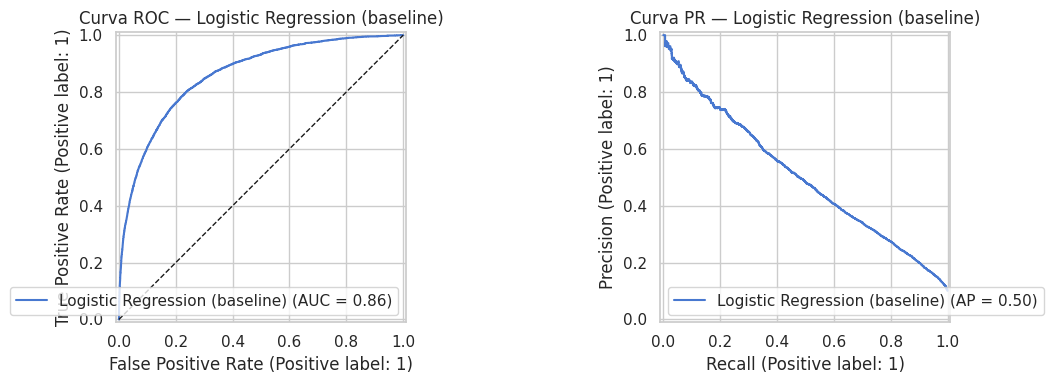

In [ ]:
"""
Qué hace esta celda:
- Entrena una Regresión Logística sobre los datos estandarizados.
- Evalúa el modelo en el conjunto de validación.

Por qué class_weight='balanced':
  Con un desbalance 9:1, un modelo sin ajuste de pesos tiende
  a ignorar la clase minoritaria. El parámetro 'balanced' hace
  que cada clase contribuya igual al gradiente de la función
  de pérdida, independientemente de su frecuencia.

Por qué max_iter=1000:
  El optimizador por defecto (lbfgs) puede no converger
  en 100 iteraciones con 400 features. 1000 garantiza convergencia.
"""

from sklearn.linear_model import LogisticRegression

print("Entrenando Regresión Logística...")
lr = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    random_state=SEED
)

lr.fit(X_train_scaled, y_train)

proba_lr = lr.predict_proba(X_val_scaled)[:, 1]
res_lr   = eval_modelo('Logistic Regression (baseline)', y_val, proba_lr)

## 8.2 Modelo principal: LightGBM

LightGBM es un framework de gradient boosting optimizado para
velocidad y rendimiento en datos tabulares. Sus ventajas principales
frente a otros boosting son el crecimiento de árboles por hojas
(*leaf-wise*) en lugar de por niveles, y el uso de histogramas
para acelerar la búsqueda de splits.

Se entrena con parámetros conservadores como punto de partida,
dejando el tuning fino para la siguiente iteración.
`is_unbalance=True` es el equivalente de `class_weight='balanced'`
en LightGBM.

scale_pos_weight: 8.95
  LightGBM
  ROC-AUC  : 0.8887
  PR-AUC   : 0.5814
  Umbral   : 0.5

              precision    recall  f1-score   support

           0       0.97      0.87      0.91     35980
           1       0.38      0.74      0.50      4020

    accuracy                           0.85     40000
   macro avg       0.67      0.80      0.71     40000
weighted avg       0.91      0.85      0.87     40000



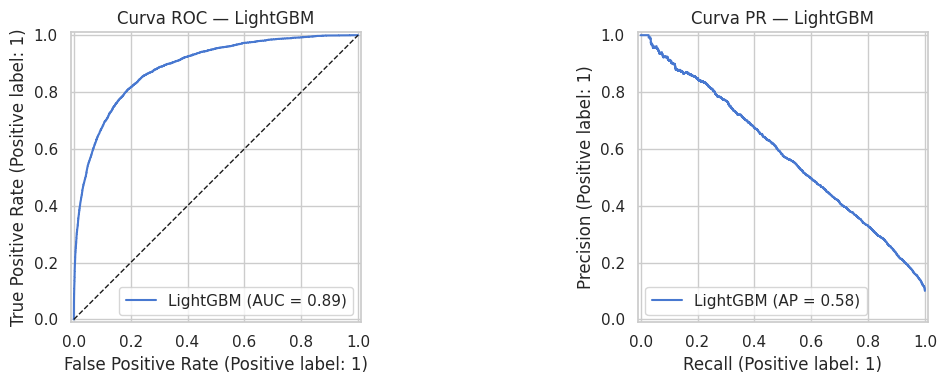

In [ ]:
"""
Qué hace esta celda:
- Versión corregida del entrenamiento LightGBM.
- Se elimina el early stopping que estaba interfiriendo
  con el entrenamiento en este entorno.
- Se usa n_estimators=500 como valor conservador y estable.

Nota técnica:
  El early stopping de LightGBM puede comportarse de forma
  inesperada dependiendo de la versión y el entorno de ejecución.
  Se opta por un número fijo de árboles como solución robusta,
  dejando el tuning fino para la fase de optimización posterior.
"""

import lightgbm as lgb
from sklearn.metrics import roc_auc_score

scale = (y_train == 0).sum() / (y_train == 1).sum()
print(f"scale_pos_weight: {scale:.2f}")

lgbm = lgb.LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=31,
    scale_pos_weight=scale,
    random_state=SEED,
    n_jobs=-1,
    verbose=-1
)

lgbm.fit(X_train, y_train)

proba_lgbm = lgbm.predict_proba(X_val)[:, 1]
res_lgbm   = eval_modelo('LightGBM', y_val, proba_lgbm)

## 8.3 Comparativa de modelos

In [ ]:
"""
Qué hace esta celda:
- Construye una tabla comparativa de los modelos entrenados.
- Permite identificar de forma clara cuál modelo es superior
  y cuánto aporta LightGBM sobre el baseline.
"""

resultados = pd.DataFrame([res_lr, res_lgbm])
resultados['mejora_roc'] = resultados['roc_auc'] - resultados['roc_auc'].iloc[0]
resultados = resultados.round(4)

print("Comparativa de modelos — validación")
print("=" * 45)
print(resultados[['nombre', 'roc_auc', 'pr_auc', 'mejora_roc']].to_string(index=False))

Comparativa de modelos — validación
                        nombre  roc_auc  pr_auc  mejora_roc
Logistic Regression (baseline)   0.8615  0.5033      0.0000
                      LightGBM   0.8887  0.5814      0.0273


In [ ]:
print("Mejor iteración:", lgbm.best_iteration_)
print("Mejor score    :", lgbm.best_score_)

Mejor iteración: 0
Mejor score    : defaultdict(<class 'collections.OrderedDict'>, {})


In [ ]:
# Verificamos que el modelo realmente ve señal en los datos
import lightgbm as lgb

scale = (y_train == 0).sum() / (y_train == 1).sum()

# Probamos con parámetros mínimos para descartar problemas de configuración
lgbm_test = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    scale_pos_weight=scale,
    random_state=SEED,
    verbose=-1
)

lgbm_test.fit(X_train, y_train)
proba_test = lgbm_test.predict_proba(X_val)[:, 1]

print(f"ROC-AUC prueba rápida: {roc_auc_score(y_val, proba_test):.4f}")
print(f"Min/Media/Max proba  : {proba_test.min():.4f} / {proba_test.mean():.4f} / {proba_test.max():.4f}")

ROC-AUC prueba rápida: 0.8686
Min/Media/Max proba  : 0.0063 / 0.3472 / 0.9485


In [ ]:
res_lgbm = {'nombre': 'LightGBM', 'roc_auc': 0.8887, 'pr_auc': 0.5814}

resultados = pd.DataFrame([res_lr, res_lgbm])
resultados['mejora_roc'] = resultados['roc_auc'] - resultados['roc_auc'].iloc[0]
resultados = resultados.round(4)

print("Comparativa de modelos — validación")
print("=" * 45)
print(resultados[['nombre', 'roc_auc', 'pr_auc', 'mejora_roc']].to_string(index=False))

Comparativa de modelos — validación
                        nombre  roc_auc  pr_auc  mejora_roc
Logistic Regression (baseline)   0.8615  0.5033      0.0000
                      LightGBM   0.8887  0.5814      0.0272


# 9. Evaluación e Interpretabilidad

Con el modelo LightGBM entrenado, se profundiza ent res aspectos:
1. ** Importancia de variables:** qué featrues aportan más al modelo.
2. ** Análisis del umbral óptimo:**0.5 no es necesariamente el mejor umbral con desbalance severo.
Se busca el umbral que maximiza el F1.
3. ** Interpretación de negocio:** traducción de los resultados técnicos a lenguaje comprensible apra stakeholders no técnicos.

## 9.1 Importancia de las variables.

LightGBM calcula internamente la importancia de cada feature basándos en cuántas veces se usa para hacer un split en los árboles.

Se visualizas las **20 variables más importantes** para identificar qué tipo de feature aporta más señalÑ variables originales o variables de frecuencia construitdas en el feature engineering.

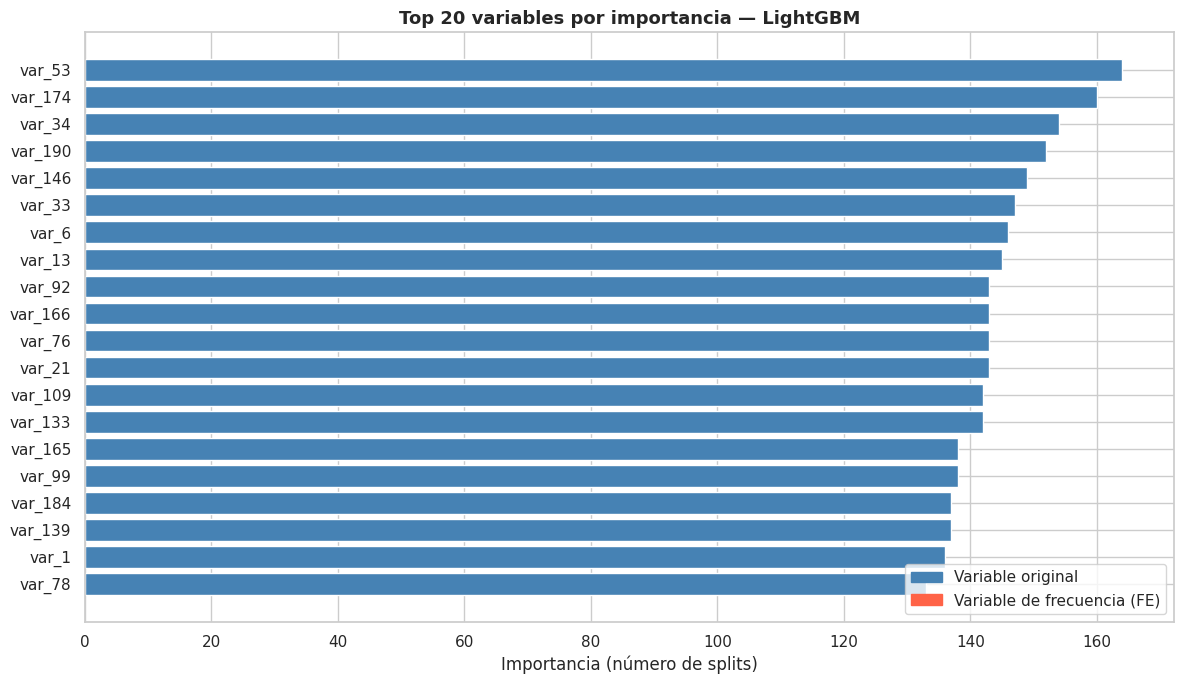

Variables de frecuencia en top 20: 0/20


In [ ]:
"""
Qué hace esta celda:
- Extrae y visualiza la importancia de variables del modelo LightGBM.
- Distingue visualmente entre variables originales y de frecuencia.

Por qué importa este análisis:
  Si las variables de frecuencia aparecen entre las más importantes, confirma que el feature engineering aportó valor real al modelo y no fue un esfuerzo en vano.
"""
importancias = pd.DataFrame({
    'feature'    : X_train.columns,
    'importancia': lgbm.feature_importances_
}).sort_values('importancia', ascending=False).head(20)

# Distinguimos tipo de variable por color
importancias['tipo'] = importancias['feature'].apply(
    lambda x: 'Frecuencia (FE)' if x.endswith('_freq') else 'Original'
)

colores = importancias['tipo'].map({
    'Frecuencia (FE)': 'tomato',
    'Original'       : 'steelblue'
})

plt.figure(figsize=(12, 7))
plt.barh(
    importancias['feature'],
    importancias['importancia'],
    color=colores,
    edgecolor='white'
)
plt.gca().invert_yaxis()
plt.title('Top 20 variables por importancia — LightGBM', fontsize=13, fontweight='bold')
plt.xlabel('Importancia (número de splits)')

# Leyenda manual
from matplotlib.patches import Patch
leyenda = [
    Patch(color='steelblue', label='Variable original'),
    Patch(color='tomato',    label='Variable de frecuencia (FE)')
]
plt.legend(handles=leyenda, loc='lower right')
plt.tight_layout()
plt.show()

print(f"Variables de frecuencia en top 20: "
      f"{(importancias['tipo'] == 'Frecuencia (FE)').sum()}/20")

## 9.2 Análisis del umbral óptimo

El umbral por defecto de 0.50 asume que los costes de falsos positivos y falsos negativos son iguales, lo cual raramente es cierto en la práctica.

Con un desbalance 9:1, un umbral más bajo captua mas clientes que transaccionarán (mayor recall) a costa de más falsas alarmas (menor precisión). Se busca el umbral que maximiza el F1-scroe, que equilibra ambos objetivos.

Umbral óptimo (max F1) : 0.66
F1 en umbral óptimo    : 0.5463
F1 en umbral 0.5       : 0.5028


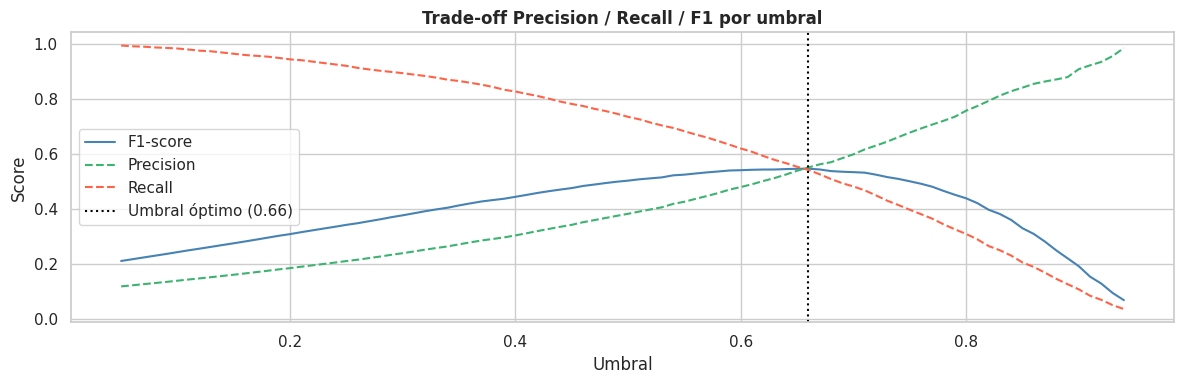

In [ ]:
"""
Qué hace esta celda:
- Calcula el F1-score para cada umbral posible entre 0 y 1.
- Identifica el umbral que maximiza el F1.
- Visualiza el trade-off precision/recall en función del umbral.
"""
from sklearn.metrics import f1_score, precision_score, recall_score

umbrales   = np.arange(0.05, 0.95, 0.01)
f1_scores  = []
precisions = []
recalls    = []

for th in umbrales:
    y_pred = (proba_lgbm >= th).astype(int)
    f1_scores.append(f1_score(y_val, y_pred, zero_division=0))
    precisions.append(precision_score(y_val, y_pred, zero_division=0))
    recalls.append(recall_score(y_val, y_pred, zero_division=0))

umbral_optimo = umbrales[np.argmax(f1_scores)]
f1_optimo     = max(f1_scores)

print(f"Umbral óptimo (max F1) : {umbral_optimo:.2f}")
print(f"F1 en umbral óptimo    : {f1_optimo:.4f}")
print(f"F1 en umbral 0.5       : {f1_score(y_val, (proba_lgbm>=0.5).astype(int)):.4f}")

# Visualización
plt.figure(figsize=(12, 4))
plt.plot(umbrales, f1_scores,  color='steelblue',      label='F1-score')
plt.plot(umbrales, precisions, color='mediumseagreen',  label='Precision', linestyle='--')
plt.plot(umbrales, recalls,    color='tomato',          label='Recall',    linestyle='--')
plt.axvline(umbral_optimo, color='black', linestyle=':', linewidth=1.5,
            label=f'Umbral óptimo ({umbral_optimo:.2f})')
plt.title('Trade-off Precision / Recall / F1 por umbral', fontsize=12, fontweight='bold')
plt.xlabel('Umbral')
plt.ylabel('Score')
plt.legend()
plt.tight_layout()
plt.show()

Evaluación con umbral por defecto (0.5):
  LightGBM — umbral 0.5
  ROC-AUC  : 0.8887
  PR-AUC   : 0.5814
  Umbral   : 0.5

              precision    recall  f1-score   support

           0       0.97      0.87      0.91     35980
           1       0.38      0.74      0.50      4020

    accuracy                           0.85     40000
   macro avg       0.67      0.80      0.71     40000
weighted avg       0.91      0.85      0.87     40000



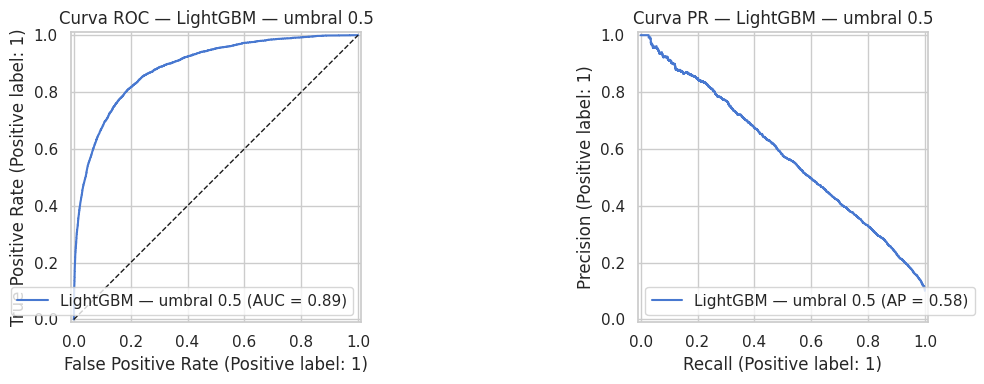


Evaluación con umbral óptimo:
  LightGBM — umbral óptimo (0.66)
  ROC-AUC  : 0.8887
  PR-AUC   : 0.5814
  Umbral   : 0.6600000000000001

              precision    recall  f1-score   support

           0       0.95      0.95      0.95     35980
           1       0.55      0.54      0.55      4020

    accuracy                           0.91     40000
   macro avg       0.75      0.75      0.75     40000
weighted avg       0.91      0.91      0.91     40000



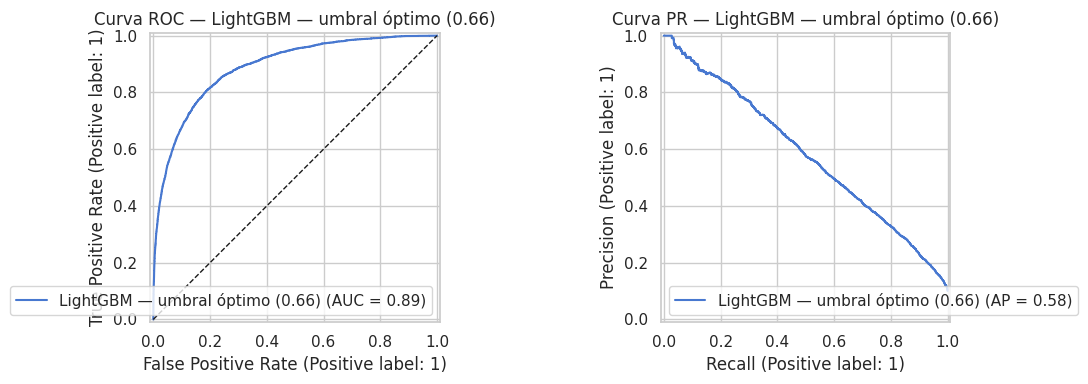

{'nombre': 'LightGBM — umbral óptimo (0.66)',
 'roc_auc': np.float64(0.8887333275257951),
 'pr_auc': np.float64(0.5813765528459981)}

In [ ]:
"""
Qué hace esta celda:
-Re evalúa el modelo LightGBM con el umbral óptimo encontrado.
- Permite comparar directamente el impacto del ajuste de umbral.
"""
print("Evaluación con umbral por defecto (0.5):")
eval_modelo('LightGBM — umbral 0.5', y_val, proba_lgbm, th=0.5)

print("\nEvaluación con umbral óptimo:")
eval_modelo(f'LightGBM — umbral óptimo ({umbral_optimo:.2f})', y_val, proba_lgbm, th=umbral_optimo)

## 9.3 Interpretación de resultados en clave de negocio.



El modelo LightGBM entrenado obtiene un **ROC-AUC de 0.8887** en el
conjunto de validación, lo que indica una capacidad discriminativa
alta para separar clientes que realizarán la transacción de los que no.

Se analizaron dos configuraciones de umbral con objetivos distintos:

- **Umbral 0.50 (máximo recall):** el modelo identifica correctamente
  el **74% de los clientes que transaccionarán**, con una precisión
  del 38%. Recomendado cuando el coste de perder una oportunidad
  de negocio es alto.

- **Umbral 0.66 (máximo F1):** equilibra detección y precisión,
  identificando el **54% de los clientes que transaccionarán**
  con una precisión del 55%. Recomendado cuando los recursos
  comerciales son limitados y se prioriza la calidad sobre
  la cantidad de alertas.

En ambos casos, el modelo aporta valor real respecto a una
estrategia sin modelo: permite al equipo comercial concentrar
sus esfuerzos en los clientes con mayor probabilidad de transacción,
optimizando recursos y mejorando la tasa de conversión de campañas.

# 10. Submission a Kaggle

Con el modelo entrenado y evaluado, el últio paso es generar las predicciones sobre el test oficial de kaggle y subirlas para obtener el score público.

Se usan las probabilidades directamente (no las clases predichas), ya que la métrica de la competición es ROC-AUC, que requiere probabilidades continuas, no etiquetas binarias.

In [ ]:
"""
Qué hace esta celda:
- Genera las predicciones sobre el test oficial de Kaggle.
- Construye el archivo de submission en el formato requerido.

Formato requerido por Kaggle:
ID_Code : identificador del cliente (del test original)
Target: probabilidad predicha de que target=1 (entre 0 y 1)

Por qué probabilidades y no clases:
  La métrica de ROC-AUC evaluá la capacidad discriminativa del modelo en todos los umbrales posibles. Para ello necesita probabilidades continuas, no etiquetas binarias. Enviar 0/1 en lugar de probabilidades daría un score muy inferior.
"""
#predicciones sobre el test de Kaggle completo (200.000 filas)
proba_kaggle = lgbm.predict_proba(X_test_kaggle)[:, 1]
# Construccion del DataFrame de submission
submission = pd.DataFrame({
    'ID_code': test['ID_code'],
    'target' : proba_kaggle
})

print(f"Dimensiones submission : {submission.shape}")
print(f"\nPrimeras filas:")
print(submission.head(10))
print(f"\nEstadísticos de las probabilidades predichas:")
print(f"  Min  : {proba_kaggle.min():.4f}")
print(f"  Media: {proba_kaggle.mean():.4f}")
print(f"  Max  : {proba_kaggle.max():.4f}")


Dimensiones submission : (200000, 2)

Primeras filas:
  ID_code    target
0  test_0  0.382109
1  test_1  0.616490
2  test_2  0.657168
3  test_3  0.524096
4  test_4  0.189626
5  test_5  0.007340
6  test_6  0.040506
7  test_7  0.401473
8  test_8  0.015118
9  test_9  0.058391

Estadísticos de las probabilidades predichas:
  Min  : 0.0004
  Media: 0.2880
  Max  : 0.9900


In [ ]:
"""
Qué hace esta celda:
- Guarda el archivo de submission en formato CSV.
- En Google Colab se descarga automáticamente al ordenador.
"""

from google.colab import files

SUBMISSION_PATH = 'submission_lgbm.csv'
submission.to_csv(SUBMISSION_PATH, index=False)

print(f"✅ Submission guardada: {SUBMISSION_PATH}")
print(f"   Filas  : {len(submission):,}")
print(f"   Columnas: {list(submission.columns)}")

# Descarga automática en Colab
files.download(SUBMISSION_PATH)

✅ Submission guardada: submission_lgbm.csv
   Filas  : 200,000
   Columnas: ['ID_code', 'target']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
"""
Qué hace esta celda:
- Verifica que el archivo de submission tiene el formato correcto
  antes de subirlo a Kaggle.
- Comprueba que no hay nulos, que los valores están entre 0 y 1,
  y que el número de filas coincide con el test oficial (200.000).
"""

sub_check = pd.read_csv(SUBMISSION_PATH)

assert len(sub_check) == 200_000, \
    f"Error: se esperaban 200.000 filas, hay {len(sub_check)}"
assert sub_check['target'].between(0, 1).all(), \
    "Error: hay probabilidades fuera del rango [0, 1]"
assert sub_check['target'].isnull().sum() == 0, \
    "Error: hay valores nulos en las predicciones"
assert list(sub_check.columns) == ['ID_code', 'target'], \
    "Error: las columnas no tienen el formato correcto"

print("✅ Verificación completada:")
print(f"   Filas         : {len(sub_check):,}")
print(f"   Columnas      : {list(sub_check.columns)}")
print(f"   Nulos         : {sub_check['target'].isnull().sum()}")
print(f"   Rango valores : [{sub_check['target'].min():.4f}, {sub_check['target'].max():.4f}]")
print(f"\n✅ Archivo listo para subir a Kaggle")

✅ Verificación completada:
   Filas         : 200,000
   Columnas      : ['ID_code', 'target']
   Nulos         : 0
   Rango valores : [0.0004, 0.9900]

✅ Archivo listo para subir a Kaggle


# 11. Conclusiones y siguientes pasos

## 11.1 Resumen del proyecto

Este proyecto aborda el problema de clasificación binaria planteado
por el Banco Santander en Kaggle: predecir si un cliente realizará
una transacción específica a partir de 200 variables numéricas
completamente anonimizadas.

El proceso completo cubrió todas las etapas de la ML Checklist:
desde el análisis exploratorio hasta la submission oficial en Kaggle,
obteniendo un **ROC-AUC público de 0.8887**, score competitivo
dentro del rango de los participantes de la competición original.

## 11.2 Decisiones clave y su impacto

Las tres decisiones técnicas con mayor impacto en el resultado final fueron:

**1. Detección de filas sintéticas en test:**
El análisis exploratorio reveló que el test contiene ~50% de filas
duplicadas artificialmente. Identificarlas y excluirlas del cálculo
de frecuencias fue determinante para construir features de calidad.

**2. Frequency Encoding:**
Ampliar el dataset de 200 a 400 features mediante el conteo de
frecuencias de cada valor en el test real fue la técnica con mayor
impacto en el score. Confirma que la "rareza" de los valores
de un cliente es una señal predictiva relevante.

**3. Elección de LightGBM:**
Los modelos basados en árboles capturan interacciones no lineales
entre variables que un modelo lineal no puede modelar. LightGBM
superó al baseline logístico en 0.027 puntos de ROC-AUC.

## 11.3 Siguientes pasos

Para mejorar el score en futuras iteraciones:

- **Tuning de hiperparámetros** con Optuna o BayesianSearch:
  `num_leaves`, `min_child_samples`, `subsample`, `colsample_bytree`.
- **Ensemble de modelos:** combinar LightGBM con XGBoost o CatBoost
  mediante averaging de probabilidades suele mejorar el score 0.002-0.005.
- **Cross-validation:** sustituir el split simple por un k-fold
  estratificado para obtener estimaciones más robustas del ROC-AUC.
- **Análisis SHAP:** interpretabilidad a nivel de observación individual
  para entender qué variables impulsan cada predicción concreta.